### Dogs or Cats 

First Version about VGG-19 (working progress....) 


<br>

### 1. Frameworks 

In [1]:
import os 
import glob 
import zipfile
import re 
import time 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns 
import random 

%matplotlib inline 
import warnings 
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, InputLayer
from tensorflow.keras.layers import SpatialDropout2D, GlobalMaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
# Seed 
tf.random.set_seed(42)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU device: {}'.format(tf.test.gpu_device_name()))
else: 
    print('Please install GPU for tensorflow')

Default GPU device: /device:GPU:0


In [5]:
# zipfiles 
zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [6]:
# filenames
print(os.listdir('../input/dogs-vs-cats'))

['sampleSubmission.csv', 'test1.zip', 'train.zip']


In [7]:
# import files 

image_folder = ('../working/train')
filenames = os.listdir(image_folder)


classes=list()
full_paths=list()
for file in filenames:
    target=file.split(".")[0]
    full_path=os.path.join(image_folder, file)
    full_paths.append(full_path)
    classes.append(target)

data=pd.DataFrame()
data['path']=full_paths
data['label']=classes

In [8]:
# dataset
data.head()

,path,label
0,../working/train/dog.11773.jpg,dog
1,../working/train/dog.8032.jpg,dog
2,../working/train/dog.4330.jpg,dog
3,../working/train/cat.3112.jpg,cat
4,../working/train/cat.8677.jpg,cat


In [9]:
# Count images
classes_count = data['label'].value_counts()

print('Count dog images: {}'.format(classes_count['dog']))
print('Count dog images: {}'.format(classes_count['cat']))

Count dog images: 12500
Count dog images: 12500


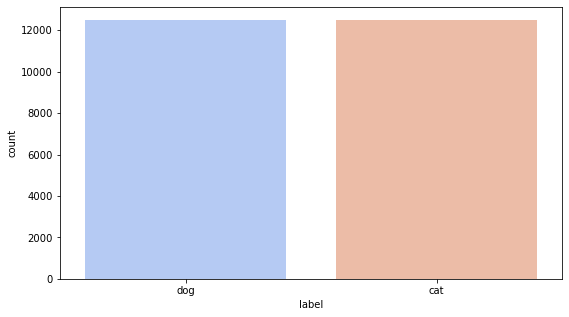

In [10]:
# classes count 
plt.figure(figsize=(9,5))
sns.countplot(data['label'], palette='coolwarm')

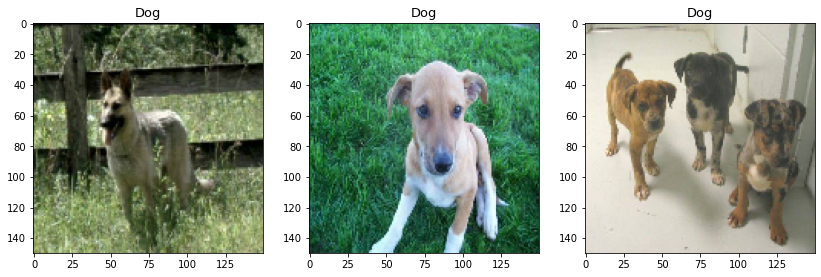

In [11]:
# spliting images 

dogs_list = ['../working/train/dog.11618.jpg', '../working/train/dog.4341.jpg', '../working/train/dog.8119.jpg']

plt.figure(figsize=(14,7))

for image in range(0,3):
    plt.subplot(1,3, image +1)
    image = load_img(dogs_list[image], target_size=(150,150))
    plt.imshow(image)
    plt.title('Dog', fontsize=13)
plt.show()

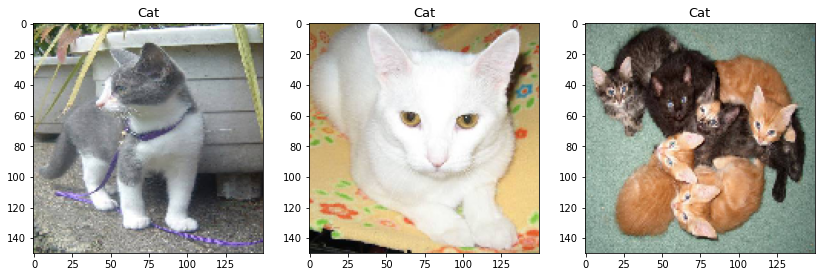

In [12]:
cats_list = ['../working/train/cat.1654.jpg', '../working/train/cat.4341.jpg', '../working/train/cat.8119.jpg']

plt.figure(figsize=(14,7))
        
           
for image in range(0,3):
    plt.subplot(1,3, image +1)
    image = load_img(cats_list[image], target_size=(150,150))
    plt.imshow(image)
    plt.title('Cat', fontsize=13)
plt.show()

In [13]:
# Images shape  
image = load_img('../working/train/dog.1273.jpg', target_size=(150,150))
image = img_to_array(image)
image.shape

(150, 150, 3)

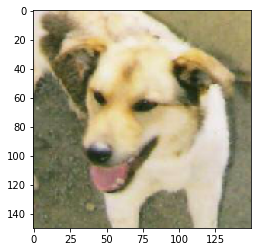

In [14]:
# show image 
image = array_to_img(image)
plt.imshow(image, cmap='gray')

<br>
<hr>
<br>


### Build Convolutional Neural Network 


<br>

In [15]:
# CNN Archicture 


def cnn(input_shape, block1, block2, block3, block4):
    
   # sequential and input  
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
   
   # Block 1 | Convolutional
    model.add(Conv2D(filters=block1[0], kernel_size=block1[1], strides=block1[2], padding=block1[3], activation='relu'))
    model.add(Conv2D(filters=block1[0], kernel_size=block1[1], strides=block1[2], padding=block1[3], activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    
    
    
   # Block 2 | Convolutional 
    model.add(Conv2D(filters=block2[0], kernel_size=block2[1], strides=block2[2], padding=block2[3], activation='relu'))
    model.add(Conv2D(filters=block2[0], kernel_size=block2[1], strides=block2[2], padding=block2[3], activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.20))
    
    
              
    # Block 3 | Convolutional 
    model.add(Conv2D(filters=block3[0], kernel_size=block3[1], strides=block3[2], padding=block3[3], activation='relu'))
    model.add(Conv2D(filters=block3[0], kernel_size=block3[1], strides=block3[2], padding=block3[3], activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.20))
    
    
    # Block 4 | Convolutional 
    model.add(Conv2D(filters=block4[0], kernel_size=block4[1], strides=block4[2], padding=block4[3], activation='relu'))
    model.add(Conv2D(filters=block4[0], kernel_size=block4[1], strides=block4[2], padding=block4[3], activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.20))
    
    
              
    # Block 5 | GlobalMaxPooling + Fully Connected + Output Layer 
    model.add(GlobalMaxPool2D())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
              
    
    return model


In [16]:
# defines parameters and blocks 

image_size = 150
input_shape = (image_size, image_size, 3)



epochs = 50
batch = 160
optimizer = RMSprop(learning_rate=1e-4)
metrics = ['accuracy']
loss = BinaryCrossentropy()


block1 = [32, (3,3), (1,1), 'same']
block2 = [64, (3,3), (1,1), 'same']
block3 = [128, (3,3), (1,1), 'same']
block4 = [32, (3,3), (1,1), 'same']


model = cnn(input_shape=input_shape, block1=block1, block2=block2, block3=block3, block4=block4)

model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        2

In [17]:
# spliting dataset 

train, test = train_test_split(data, test_size=0.30, random_state=42)

print('train shape: {} | test shape: {}'.format(train.shape, test.shape))

train shape: (17500, 2) | test shape: (7500, 2)


<br>


### Data Augmentation 




In [18]:
# train generator

generator_train = ImageDataGenerator(horizontal_flip=True,
                             rotation_range=15,
                             shear_range=0.1,
                             zoom_range=0.20, 
                             rescale=1./255,
                             width_shift_range=0.1,
                             height_shift_range=0.1,                            
                             )



train_generator = generator_train.flow_from_dataframe(dataframe=train,
                            x_col='path',
                            y_col='label',                
                            target_size=(image_size,image_size),
                            color_mode='rgb',
                            class_mode='binary',
                            batch_size=150
                            )

Found 17500 validated image filenames belonging to 2 classes.


In [19]:
# test generator 
generator_test= ImageDataGenerator(rescale=1./255)


test_generator = generator_test.flow_from_dataframe(dataframe=test,
                            x_col='path',
                            y_col='label',                
                            target_size=(image_size,image_size),
                            color_mode='rgb',
                            class_mode='binary',
                            batch_size=150
                            )

Found 7500 validated image filenames belonging to 2 classes.


In [20]:
%%time


history = model.fit(train_generator, validation_data=test_generator,
            epochs=50, 
            validation_steps=test.shape[0]//150,
            steps_per_epoch=train.shape[0]//150)

Epoch 1/50
116/116 [==============================] - 171s 1s/step - loss: 0.6522 - accuracy: 0.6199 - val_loss: 0.6933 - val_accuracy: 0.5013
Epoch 2/50
116/116 [==============================] - 172s 1s/step - loss: 0.6031 - accuracy: 0.6697 - val_loss: 0.6966 - val_accuracy: 0.5013
Epoch 3/50
116/116 [==============================] - 171s 1s/step - loss: 0.5688 - accuracy: 0.7022 - val_loss: 0.7017 - val_accuracy: 0.5013
Epoch 4/50
116/116 [==============================] - 172s 1s/step - loss: 0.5410 - accuracy: 0.7252 - val_loss: 0.7559 - val_accuracy: 0.5019
Epoch 5/50
116/116 [==============================] - 171s 1s/step - loss: 0.5142 - accuracy: 0.7469 - val_loss: 0.8684 - val_accuracy: 0.5257
Epoch 6/50
116/116 [==============================] - 172s 1s/step - loss: 0.4867 - accuracy: 0.7633 - val_loss: 0.6643 - val_accuracy: 0.6147
Epoch 7/50
116/116 [==============================] - 170s 1s/step - loss: 0.4640 - accuracy: 0.7794 - val_loss: 0.4627 - val_accuracy: 0.7893

In [21]:
loss, accuracy = model.evaluate(test_generator, batch_size=150)

50/50 [==============================] - 22s 439ms/step - loss: 0.1976 - accuracy: 0.9156


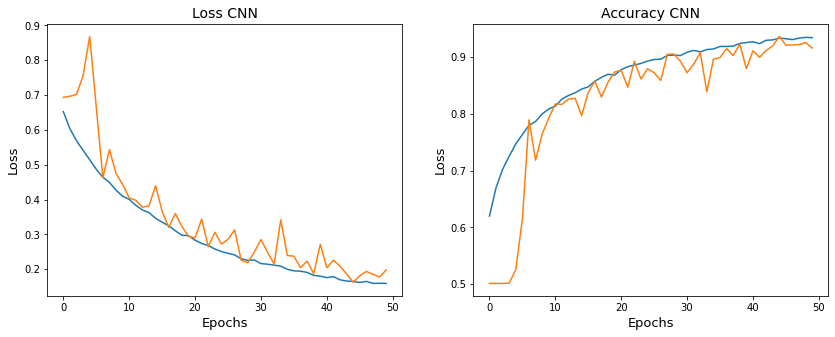

In [22]:
# evaluation  

epochs = [i for i in range(0,50)]

fig, ax = plt.subplots(1,2, figsize=(14,5))


# Loss 
ax[0].plot(epochs, history.history['loss'], label='train loss')
ax[0].plot(epochs, history.history['val_loss'], label='train loss')
ax[0].set_xlabel('Epochs', fontsize=13)
ax[0].set_ylabel('Loss', fontsize=13)
ax[0].set_title('Loss CNN', fontsize=14)


# Accuracy 
ax[1].plot(epochs, history.history['accuracy'], label='train accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='test accuracy')
ax[1].set_xlabel('Epochs', fontsize=13)
ax[1].set_ylabel('Loss', fontsize=13)
ax[1].set_title('Accuracy CNN', fontsize=14)

plt.show()


In [23]:
print('Accuracy: {} | Loss: {}'.format(accuracy, loss))

Accuracy: 0.9156000018119812 | Loss: 0.1976485550403595


<br>

## Transfer learning VGG-19 




In [24]:
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(150,150,3))


    
for layer in vgg19_model.layers[:15]:
    layer.trainable = False

for layer in vgg19_model.layers[15:]:
    layer.trainable = True
    
    
last_layer = vgg19_model.get_layer('block5_pool')
last_output = last_layer.output
    

x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(vgg19_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [25]:
train_images, test_images = train_test_split(data, test_size=0.30, random_state=42)

total_train = train_images.shape[0]
total_test = test_images.shape[0]

batch_size=16

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)




train_generator = train_datagen.flow_from_dataframe(
    train_images,  
    x_col='path',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=batch
)

Found 17500 validated image filenames belonging to 2 classes.


In [27]:

test_datagen = ImageDataGenerator(rescale=1./255)



test_generator = test_datagen.flow_from_dataframe(
    test_images,  
    x_col='path',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=batch
)

Found 7500 validated image filenames belonging to 2 classes.


In [28]:
%%time 

model.fit(train_generator, validation_data=test_generator,
            epochs=20,
            validation_steps=total_train//batch_size,
            steps_per_epoch=total_test//batch_size)

Epoch 1/20
110/468 [======>.......................] - 298s 3s/step - loss: 0.6335 - accuracy: 0.6403 - val_loss: 0.3831 - val_accuracy: 0.8655
CPU times: user 5min, sys: 28.1 s, total: 5min 28s
Wall time: 5min 6s


In [29]:
loss, accuracy = model.evaluate(test_generator)

47/47 [==============================] - 32s 688ms/step - loss: 0.3831 - accuracy: 0.8655


### Submission 

In [30]:
nb_samples = test_images.shape[0]

In [31]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

threshold = 0.5
test_images['category'] = np.argmax(predict, axis=-1) #alterar para -1 

In [32]:
submission_df = test_images.copy()
submission_df['id'] = submission_df['path'].str.split('.').str[0]
submission_df['label'] = submission_df['label']
submission_df.drop(['path', 'label'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)